# Performance on simulated electrons and photons

In [3]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from general_functions import *
from loaders import *
from initializers import initialisation_for_calorimetry_shower

In [4]:
today = '20_02_12'

In [5]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/shower_calo/pdfs/
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/shower_calo/'
save_folder_pdfs = save_folder + 'pdfs/'

## Loading and initializing

In [6]:
branches = [
    'run',
    'sub',
    'evt',
    
    'generation',
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
    'backtracked_start_x',
    'backtracked_start_y',
    'backtracked_start_z',
    'backtracked_start_t',
    'backtracked_sce_start_x',
    'backtracked_sce_start_y',
    'backtracked_sce_start_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'trk_start_x',
    'trk_start_y',
    'trk_start_z',
    
    'trk_sce_start_x',
    'trk_sce_start_y',
    'trk_sce_start_z',

    'trk_end_x',
    'trk_end_y',
    'trk_end_z',
    
    'trk_sce_end_x',
    'trk_sce_end_y',
    'trk_sce_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',

    'trk_len',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
    'x_u',
    'x_v',
    'x_y',
    
    'y_u',
    'y_v',
    'y_y',
    
    'z_u',
    'z_v',
    'z_y',
    
    'dir_x_u',
    'dir_x_v',
    'dir_x_y',
    
    'dir_y_u',
    'dir_y_v',
    'dir_y_y',
    
    'dir_z_u',
    'dir_z_v',
    'dir_z_y',
]

In [7]:
# Declaring files, folder and tree

directory = '~/Desktop/MicroBooNE/calorimetry_likelihood/v05/'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.2
split_factor2 = 0.4

file_lists = {}
arrays_train = {}
arrays_test = {}

file_lists['nue'] = directory + 'bnb_nue_shr/out.root'
file_lists['ccpi0'] = directory + 'bnb_ccpi0_shr/out.root'
file_lists['ncpi0'] = directory + 'bnb_ncpi0_shr/out.root'

In [8]:
#Loading arrays
for name, file_path in file_lists.items():
    root_file = uproot.open(file_path)[folder][tree]
    entry_split = int(len(root_file) * split_factor)
    entry_split2 = int(len(root_file) * split_factor2)
    arrays_train[name] = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
    arrays_test[name] = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [9]:
# Merging nue, nu, and ncpi0
array_train = {}
array_test = {}
for variable in branches:
    array_train[variable] = awkward.concatenate([array[variable] for array in arrays_train.values()])    
    array_test[variable] = awkward.concatenate([array[variable] for array in arrays_test.values()])

In [10]:
# initialising arrays
for array in [array_train, array_test]:
    initialisation_for_calorimetry_shower(array)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/general_functions.py:89: RuntimeWarning: overflow encountered in square
  (point1_y - point2_y)**2 +
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/general_functions.py:90: RuntimeWarning: overflow encountered in square
  (point1_z - point2_z)**2 )
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in subtract
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
def selection_for_train(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['distance_3d_start'] < 2) &\
           (array['distance_3d_start'] > 0) &\
           ((array['dedx_u'].count() + array['dedx_v'].count() + array['dedx_y'].count()) > 0 ) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

def selection_for_test(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['distance_3d_start'] < 2) &\
           ((array['dedx_u'].count() + array['dedx_v'].count() + array['dedx_y'].count()) > 0 ) &\
           (array['distance_3d_start'] > 0)

def electron_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==11)

def photon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==22)

def cosmic_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==0)

In [13]:
#declaring some masks
selection_train = selection_for_train(array_train)
selection_test = selection_for_test(array_test)

electron_train = (abs(array_train['backtracked_pdg']) == 11)
photon_train = (abs(array_train['backtracked_pdg']) == 22)

electron_test = (abs(array_test['backtracked_pdg']) == 11)
photon_test = (abs(array_test['backtracked_pdg']) == 22)

In [14]:
# Easy start point resolution studies

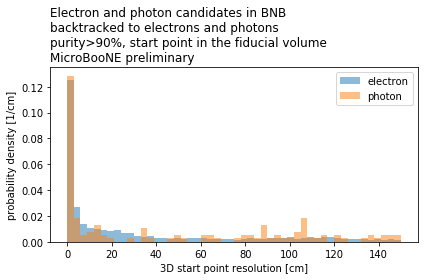

In [15]:
def base_selection_for_res_start_study(array):
    return (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['backtracked_e'] > 1) &\
           ((abs(array['backtracked_pdg']) == 11) | (abs(array['backtracked_pdg']) == 22))

base_sel = base_selection_for_res_start_study(array_train)
plt.hist(array_train['distance_3d_start'][electron_train & base_sel], bins=50, range=[0, 150], alpha=0.5, density=True, label='electron')
plt.hist(array_train['distance_3d_start'][photon_train & base_sel], bins=50, range=[0, 150], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('3D start point resolution [cm]')
plt.ylabel('probability density [1/cm]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
# plt.savefig(save_folder + 'electron_photon_startpoint_res.png', dpi=250)

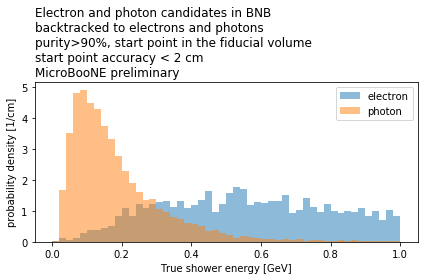

In [16]:
plt.hist(array_train['backtracked_e'][electron_train & selection_train], bins=50, range=[0, 1], alpha=0.5, density=True, label='electron')
plt.hist(array_train['backtracked_e'][photon_train & selection_train], bins=50, range=[0, 1], alpha=0.5, density=True, label='photon')
plt.legend()
plt.xlabel('True shower energy [GeV]')
plt.ylabel('probability density [1/cm]')
plt.title('Electron and photon candidates in BNB\nbacktracked to electrons and photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder + 'electron_photon_shower_energy.png', dpi=250)

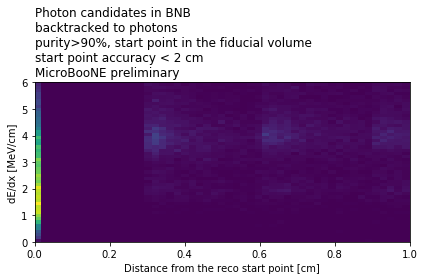

In [17]:
dedx_y = array_train['dedx_y'][photon_train & selection_train]
dist = array_train['range_y'][photon_train & selection_train]

plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 1], [0, 6]], bins=[51, 51])
plt.xlabel("Distance from the reco start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Photon candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
# plt.savefig(save_folder + 'photon_2d_dedx_dist.png', dpi=250)

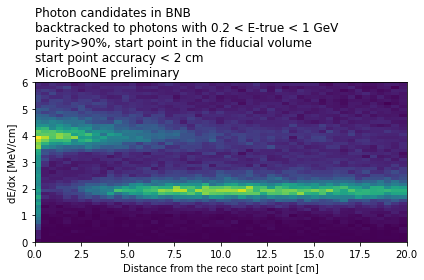

In [18]:
sh_energy_bins = [0, 0.1, 0.2, 1]
for sh_en_low, sh_en_high in zip(sh_energy_bins[:-1], sh_energy_bins[1:]):
    sh_en_mask = (array_train['backtracked_e'] > sh_en_low) & (array_train['backtracked_e'] <= sh_en_high)
    dedx_y = array_train['dedx_y'][photon_train & selection_train & sh_en_mask]
    dist = array_train['range_y'][photon_train & selection_train & sh_en_mask]
    
    plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51])
    plt.xlabel("Distance from the reco start point [cm]")
    plt.ylabel("dE/dx [MeV/cm]")
    plt.title('Photon candidates in BNB\nbacktracked to photons with {:.2g} < E-true < {:.2g} GeV\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary'
              .format(sh_en_low, sh_en_high), loc='left')
    plt.tight_layout()
    plt.savefig(save_folder + 'photon_2d_dedx_dist_sh_energy_{:.2g}_{:.2g}.png'.format(sh_en_low, sh_en_high), dpi=250)

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)


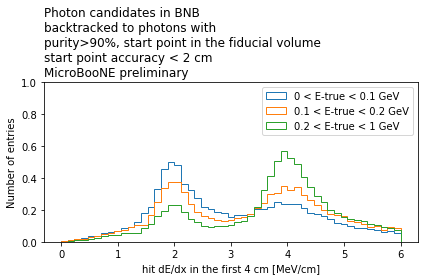

In [19]:
sh_energy_bins = [0, 0.1, 0.2, 1]
for sh_en_low, sh_en_high in zip(sh_energy_bins[:-1], sh_energy_bins[1:]):
    sh_en_mask = (array_train['backtracked_e'] > sh_en_low) & (array_train['backtracked_e'] <= sh_en_high)
    dist_mask = array_train['range_y'] < 4
    dedx_y = array_train['dedx_y'][photon_train & selection_train & dist_mask & sh_en_mask]
    
    plt.hist(dedx_y.flatten(), 
             range=[0, 6], 
             bins=51, 
             density=True,
             histtype='step',
             label='{:.2g} < E-true < {:.2g} GeV'.format(sh_en_low, sh_en_high))
    
plt.ylabel("Number of entries")
plt.xlabel("hit dE/dx in the first 4 cm [MeV/cm]")
plt.legend()
plt.ylim(0, 1)
plt.title('Photon candidates in BNB\nbacktracked to photons with \npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder + 'photon_1d_dedx_sh_energy.png', dpi=250)

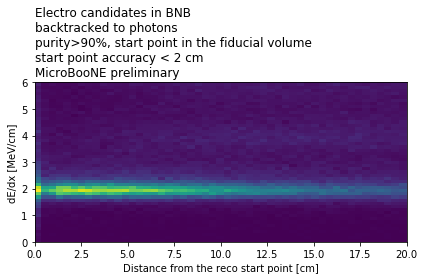

In [20]:
dedx_y = array_train['dedx_y'][electron_train & selection_train]
dist = array_train['range_y'][electron_train & selection_train]

plt.hist2d(dist.flatten(), dedx_y.flatten(), range=[[0, 20], [0, 6]], bins=[51, 51])
plt.xlabel("Distance from the reco start point [cm]")
plt.ylabel("dE/dx [MeV/cm]")
plt.title('Electro candidates in BNB\nbacktracked to photons\npurity>90%, start point in the fiducial volume\nstart point accuracy < 2 cm\nMicroBooNE preliminary', loc='left')
plt.tight_layout()
plt.savefig(save_folder + 'electron_2d_dedx_dist.png', dpi=250)

## Lookup Tables

In [24]:
# two parameters
parameters_names = ['dist_from_start', 'pitch']
parameters_bin_edges = [[0., 1, 2, 3, 4, 5, 10, 1000],
                  [0.3, 0.6, 1., 1.5, 3000]]

dedx_var = 'dedx'
dedx_bins = [0.        , 0.31578947, 0.63157895, 0.94736842, 1.26315789,
       1.57894737, 1.89473684, 2.21052632, 2.52631579, 2.84210526,
       3.15789474, 3.47368421, 3.78947368, 4.10526316, 4.42105263,
       4.73684211, 5.05263158, 5.36842105, 5.68421053, 6. , 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 30, 50]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [25]:
# declaring caloLikelihood objects
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [26]:
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 11)    
    caloLike_train.buildLookUpTableMC(i, 22)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [11, 22])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:146: RuntimeWarning: divide by zero encountered in log
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:146: RuntimeWarning: invalid value encountered in subtract
  np.log(table_1) - np.log(table_2),


In [27]:
caloLike_train.addCalorimetryVariables(caloLike_test.array, pdg_codes=[11, 22], cali=False)
caloLike_train.addCalorimetryVariablesFromLLRTable(caloLike_test.array, cali=False)

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:251: RuntimeWarning: divide by zero encountered in log
  return np.log(self.lookup_tables[pdg_code][plane_num][lookup_index])
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:298: RuntimeWarning: invalid value encountered in subtract
  array['log_like_ratio_{}'.format(plane)] = array['like_{}_sum_{}'.format(pdg_codes[0], plane)] - array['like_{}_sum_{}'.format(pdg_codes[1], plane)]
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:300: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/lib/calo_likelihood.py:301: RuntimeWarning: invalid value encountered in add
  array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']


In [29]:
caloLike_train.printCplusplusLookUp(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/LLRPID_electron_photon_lookup.h', 
                                    name='ELECTRON_PHOTON', struct_name='ElectronPhotonLookUpParameters',
                                    planes=[0, 1, 2])

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [30]:
# Plot PDF 2parameters
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=11, 
                                  parameters_value=bin_center, 
                                  label='electron')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=22, 
                                  parameters_value=bin_center, 
                                  label='photon')
        plt.xlim(0, 10)
        plt.tight_layout()
        plt.savefig(save_folder_pdfs+'plane_{}_dist_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]), dpi=250)
        plt.close()

## Plots

In [12]:
for array in [array_train, array_test]:
    for plane in ['_u', '_v', '_y']:
        aux_array = array['dedx'+plane][array['range'+plane]<4]
        out_array = []
        for i in aux_array:
            if len(i) == 0:
                out_array.append(-np.inf)
            else:
                out_array.append(np.median(i))
        array['dedx_median_4'+plane] = np.array(out_array)

/home/nic/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
def add_norm_variable(array, var, scale=100):
    array[var+'_n'] = 2/math.pi*np.arctan(array[var]/scale)

In [20]:
sel = selection_test & (electron_test | photon_test)
(array_test['dedx_median_4_y'][sel]<0).sum()/len(array_test['dedx_median_4_y'][sel])

0.0695322376738306

In [ ]:
interesting_variables = [
                         'dedx_median_4_u',
                         'dedx_median_4_v',
                         'dedx_median_4_y',
                         'llr_sum_0',
                         'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

variable_labels = {
    'dedx_median_4_u': 'dE/dx U median-4cm',
    'dedx_median_4_v': 'dE/dx V median-4cm',
    'dedx_median_4_y': 'dE/dx Y median-4cm',
    'llr_sum_0': 'LLR U',
    'llr_sum_1': 'LLR V',
    'llr_sum_2': 'LLR Y',
    'llr_01': 'LLR UV',   
    'llr_012': 'LLR UVY',   
}

for variable in interesting_variables:
    if 'llr' in variable:
        scale = 10
    elif 'bragg' in variable:
        scale = 1
    else:
        scale = 10
    add_norm_variable(caloLike_test.array, variable, scale)

In [ ]:
bins = 101
hist_range = [-1, 1]
kwargs = {'histtype':'step'}
for var in interesting_variables:
    variable = var + '_n'
    caloLike_test.plotVariableMC(variable, bins, hist_range, function_mask=electron_for_test, quality_mask=True, label='electron', **kwargs);
    caloLike_test.plotVariableMCFancy(variable, bins, hist_range, function_mask=photon_for_test, quality_mask=True, label='photon', **kwargs);
    plt.xlabel(variable_labels[var])
    plt.tight_layout()
    plt.savefig(save_folder + variable + '.png', dpi=250)
    plt.close()

In [ ]:
def electron_selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1]) &\
            electron_for_test(array)

def photon_selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1]) &\
            photon_for_test(array)

pdg_codes = [11, 22]
interesting_variables = [
#                          'dedx_median_4_u',
#                          'dedx_median_4_v',
                         'dedx_median_4_y',
#                          'llr_sum_0',
#                          'llr_sum_1',
#                          'llr_sum_2',
#                          'llr_01',
                         'llr_012',
                        ]
parameter_name = 'backtracked_e'
parameter_bin_edges = np.array([0.0, 0.1, 0.2, 0.5, 1, 1.5, 2])

bins = 101
hist_range = [-1, 1]
kwargs = {'histtype':'step'}
for sh_en_bin in zip(parameter_bin_edges[:-1], parameter_bin_edges[1:]):
    for var in interesting_variables:
        def this_electron_function(array):
            return electron_selection_function(array, parameter_name, sh_en_bin)
        def this_photon_function(array):
            return photon_selection_function(array, parameter_name, sh_en_bin)
        
        variable = var + '_n'
        caloLike_test.plotVariableMC(variable, bins, hist_range, function_mask=this_electron_function, quality_mask=True, label='electron', **kwargs);
        caloLike_test.plotVariableMCFancy(variable, bins, hist_range, function_mask=this_photon_function, quality_mask=True, label='photon', 
                                          add_to_title='\n{:.2g} < E-true < {:.2g} GeV'.format(sh_en_bin[0], sh_en_bin[1]), **kwargs);
        plt.xlabel(variable_labels[var])
        plt.tight_layout()
        plt.savefig(save_folder + variable + '_sh_energy_{:.2g}_{:.2g}.png'.format(sh_en_bin[0], sh_en_bin[1]), dpi=250)
        plt.close()

In [50]:
ar = array_test

In [51]:
mask = (ar['backtracked_e'] > 1.5) & (ar['backtracked_e'] < 2) & photon_test
# ar['dedx_y'][caloLike_test.quality_mask & (ar['backtracked_e'] > 1.5) & (ar['backtracked_e'] < 2) & photon_test]
ar['dist_from_start_y'][mask]

<JaggedArray [[32.324062 32.012726 31.701399 ... 1.5945294 1.4367614 1.3359141] [123.004616 121.22198 120.781105 ... 20.084003 20.217402 20.35663] [254.30626 254.6137 254.92143 ... 300.48898 300.82452 301.16235] ... [29.889292 29.645887 24.169157 ... 17.04682 16.740131 4.5464387] [] [33.509678 33.033195 32.55658 ... 3.3829386 3.1056144 2.896028]] at 0x7f22db018110>

In [59]:
id = 1

In [60]:
ar['dist_from_start_u'][mask][id], ar['dist_from_start_v'][mask][id], ar['dist_from_start_y'][mask][id]

(array([121.32467 , 120.92577 , 120.52858 , 119.72279 , 119.3254  ,
        118.92806 , 118.5309  , 118.1341  , 117.73747 , 117.340805,
        116.94439 , 116.54813 , 116.15198 , 115.3591  , 114.96323 ,
        114.5674  , 114.17166 , 113.77602 , 113.380486, 112.98499 ,
        112.58942 , 112.19385 , 111.79831 , 111.40285 , 111.007355,
        110.61185 , 110.21638 , 109.82083 , 109.42503 , 109.029205,
        108.63317 , 108.23697 , 107.84054 , 107.44398 , 107.047104,
        106.64998 , 106.2526  , 105.85527 , 105.457306, 105.058876,
        104.66017 , 104.259575, 103.86262 , 103.467545, 103.07238 ,
        102.67711 , 102.2818  , 101.88649 , 101.49113 , 101.09564 ,
        100.70043 , 100.305305,  99.91026 ,  99.51534 ,  99.120544,
         98.725845,  98.331314,  97.93709 ,  97.54174 ,  97.14819 ,
         96.75478 ,  96.361626,  95.96894 ,  95.57675 ,  95.18469 ,
         94.792816,  94.40112 ,  94.00962 ,  93.226006,  92.83484 ,
         92.44377 ,  92.05271 ,  91.66175 ,  91.

In [61]:
ar['range_u'][mask][id], ar['range_v'][mask][id], ar['range_y'][mask][id]

(array([128.30931   , 127.9028    , 127.49775   , 126.67899   ,
        126.27351   , 125.86807   , 125.46281   , 125.0578    ,
        124.65292   , 124.247986  , 123.84323   , 123.43854   ,
        123.03386   , 122.223885  , 121.8193    , 121.41473   ,
        121.010155  , 120.60559   , 120.201065  , 119.79651   ,
        119.39187   , 118.987206  , 118.582504  , 118.17777   ,
        117.77297   , 117.368126  , 116.96321   , 116.55816   ,
        116.15283   , 115.74737   , 115.34167   , 114.93571   ,
        114.52947   , 114.12306   , 113.71632   , 113.30924   ,
        112.90187   , 112.49446   , 112.08642   , 111.67781   ,
        111.26889   , 110.85803   , 110.45047   , 110.04449   ,
        109.63833   , 109.23201   , 108.825554  , 108.41898   ,
        108.01233   , 107.60545   , 107.19873   , 106.791985  ,
        106.38524   , 105.9785    , 105.571785  , 105.16505   ,
        104.75843   , 104.351944  , 103.94359   , 103.53764   ,
        103.13179   , 102.726036  , 102.

In [62]:
ar['x_y'][mask][id], ar['y_y'][mask][id], ar['z_y'][mask][id]

(array([ 45.15903 ,  46.220043,  46.47933 ,  46.978912,  47.24111 ,
         47.502583,  47.763695,  48.024635,  48.285187,  48.54524 ,
         48.80508 ,  49.06473 ,  49.324203,  49.58483 ,  49.843903,
         50.10287 ,  50.361763,  50.6206  ,  50.87945 ,  51.138546,
         51.398087,  51.657787,  51.917686,  52.177837,  52.438293,
         52.69911 ,  52.96053 ,  53.22246 ,  53.485104,  53.748573,
         54.01288 ,  54.277954,  54.5439  ,  54.81077 ,  55.077663,
         55.346024,  55.61568 ,  55.886303,  56.433563,  56.698326,
         56.96351 ,  57.22908 ,  57.494984,  57.761154,  58.027527,
         58.294086,  58.560505,  58.82692 ,  59.093277,  59.35973 ,
         59.625904,  59.891644,  60.169907,  60.43284 ,  60.69534 ,
         60.95737 ,  61.218895,  61.48017 ,  61.74066 ,  62.00047 ,
         62.259594,  62.517975,  63.03141 ,  63.288082,  63.54453 ,
         63.800533,  64.05635 ,  64.31158 ,  64.56653 ,  64.82126 ,
         65.0758  ,  65.58759 ,  65.84194 ,  66.

In [63]:
ar['trk_start_x'][mask][id], ar['trk_start_y'][mask][id], ar['trk_start_z'][mask][id]

(124.921684, -77.4687, 482.44974)

In [64]:
ar['evt'][mask][id], ar['run'][mask][id], ar['sub'][mask][id]

(40972, 7001, 819)

## ROC curves

In [ ]:
interesting_variables = [
                         'dedx_median_4_u',
                         'dedx_median_4_v',
                         'dedx_median_4_y',
                         'llr_sum_0',
                         'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]

for variable in interesting_variables:
    caloLike_test.rocCurve(variable=variable+'_n', 
         pdg_codes=[11, 22], 
         plot=True,
         variable_label=variable_labels[variable])

plt.title('Electron/photon separation\nSimulated tracks', loc='left')
plt.savefig(save_folder + 'roc_curves.png', dpi=250)

In [ ]:
def selection_function(array, parameter, bin_range):
    return (array[parameter] >= bin_range[0]) &\
           (array[parameter] < bin_range[1])

pdg_codes = [11, 22]
interesting_variables = [
                         'dedx_median_4_u',
                         'dedx_median_4_v',
                         'dedx_median_4_y',
                         'llr_sum_0',
                         'llr_sum_1',
                         'llr_sum_2',
                         'llr_01',
                         'llr_012',
                        ]
parameter_name = 'backtracked_e'
parameter_bin_edges = np.array([0, 0.1, 0.2, 0.5, 1, 1.5, 2])

for variable in interesting_variables:
    out = caloLike_test.auc1D(variable+'_n', 
                        pdg_codes, 
                        selection_function, 
                        parameter_name, 
                        parameter_bin_edges,
                        legend_label=variable_labels[variable])
plt.ylim(0.5, 1)
plt.xlabel(r'True shower energy [GeV]')
plt.legend()
plt.title('Electron/photon separation\nSimulated tracks', loc='left')
plt.tight_layout()
plt.savefig(save_folder+'auc1d'+parameter_name+'.png', dpi=250)

# Old

In [ ]:
norm_direction_vector(arrays_train['nue'])
out_mask = np.abs(arrays_train['nue']['norm_dir_y'] -1) > 0.001

In [ ]:
arrays_train['nue']['run'][out_mask.any()], arrays_train['nue']['sub'][out_mask.any()], arrays_train['nue']['evt'][out_mask.any()]

In [ ]:
arrays_train['nue']['dir_x_y'][out_mask.any()], arrays_train['nue']['dir_y_y'][out_mask.any()], arrays_train['nue']['dir_z_y'][out_mask.any()]